In [65]:
import pandas as pd
import numpy as np

# Read the csv files into pandas dataframes
temp_df = pd.read_csv('DesMoinesGDD.csv')
sma_df = pd.read_csv('DesMoinesGDD_rolling_average.csv')

# Merge the dataframes based on the dates column
merged_df = pd.merge(temp_df, sma_df, on='Date')

# rename the column
temp_df = temp_df.rename(columns={'Degrees Above 50': 'GDD'})

# write the DataFrame back to CSV
temp_df.to_csv('output.csv', index=False)

# Create a new column with the comparison result
merged_df['Dir'] = np.where(merged_df['Degrees Above 50'] > merged_df['GDD 15 Day SMA'], -1, 1)

# Write the final dataframe to a new csv file
merged_df.to_csv('Prediction_Data.csv', index=False, columns=['Date', 'Degrees Above 50', 'GDD 15 Day SMA', 'Dir'])

In [66]:

# read in the CSV file as a Pandas DataFrame
df = pd.read_csv('Prediction_Data.csv')

# exclude any rows with a Degrees Above 50 of zero
#df = df[df['Degrees Above 50'] != 0]

# calculate the difference between the temperature and the 15 day SMA
df['SMA Diff'] = df['Degrees Above 50'] - df['GDD 15 Day SMA']

# calculate the mean reversion rate of the temperature SMA difference
offset_factor = 1

mean_reversion_rate = 0.9132156285761*offset_factor

# print the mean reversion rate
#print(f"The overall mean reversion rate of temperature of the 15 day SMA is", mean_reversion_rate)

# calculate the predicted temperature using the previous row's SMA and mean reversion rate
#df['Predicted Temp'] = (df['GDD 15 Day SMA'].shift(1) + df['Dir'] * mean_reversion_rate).round(1)

# create a new column "Predicted Temp"
predicted_temps = []
for i, row in df.iterrows():
    if i == 0 or df.loc[i-1, 'Degrees Above 50'] == 0:
        # if the temperature of the row before is 0, predict that the next day will be zero
        predicted_temp = 0
    else:
        # predict the next day's temperature using the SMA and mean reversion rate
        prev_sma = df.loc[i-1, 'GDD 15 Day SMA']
        above_mean = 1 if df.loc[i-1, 'Dir'] == 'Above' else -1
        predicted_temp = (prev_sma + (above_mean * mean_reversion_rate)).round(1)
    predicted_temps.append(predicted_temp)

df['Predicted GDD'] = predicted_temps

# drop the 15 Day SMA and Above/Below Mean columns
df.drop(['GDD 15 Day SMA', 'Dir', 'SMA Diff'], axis=1, inplace=True)

# replace any negative values in the "Predicted Temp" column with zero
df.loc[df['Predicted GDD'] < 0, 'Predicted GDD'] = 0

# output the updated CSV
df.to_csv('DesMoines_GDD_PredictedGDD.csv', index=False)




0.8015662770171295


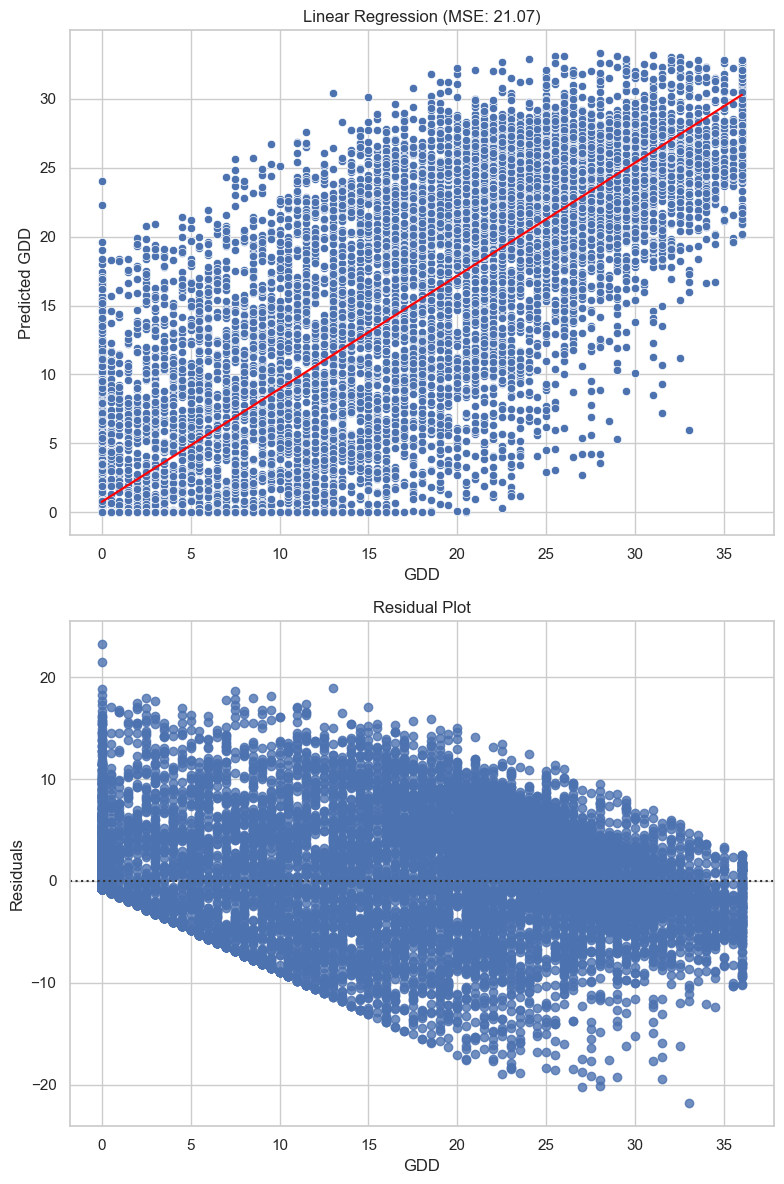

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# read in the CSV file as a Pandas DataFrame
df = pd.read_csv('DesMoines_GDD_PredictedGDD.csv')

# extract the temperature and predicted temperature columns
X = df['Degrees Above 50'][15:].values.reshape(-1, 1)
y = df['Predicted GDD'][15:].values

# calculate coefficient of correlation
R_sq = (df['Degrees Above 50'].corr(df['Predicted GDD']))**2
print(R_sq)

# fit a linear regression model to the data
lr = LinearRegression().fit(X, y)
y_pred = lr.predict(X)

# calculate the mean squared error (MSE)
mse = mean_squared_error(y, y_pred)

# plot the data points and the line of best fit
sns.set(style='whitegrid')
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 12))
sns.scatterplot(x=X.flatten(), y=y, ax=ax1)
sns.lineplot(x=X.flatten(), y=y_pred, color='red', ax=ax1)
ax1.set_xlabel('GDD')
ax1.set_ylabel('Predicted GDD')
ax1.set_title(f'Linear Regression (MSE: {mse:.2f})')

# plot the residuals
sns.residplot(x=X.flatten(), y=y, ax=ax2)
ax2.set_xlabel('GDD')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')

plt.tight_layout()
plt.show()